In [51]:
# %%
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

In [52]:

# Load dataset
df = pd.read_excel("2000_Kalimat_Kinerja_Pesantren_Unik.xlsx")
print("Contoh data:")
display(df.head(3))

# Cek distribusi label
print("\nDistribusi Sentimen:")
print(df['Sentimen'].value_counts())


Contoh data:


,No,Kalimat,Aspek,Sentimen
0,1,Pengajar memiliki kompetensi memberikan perhat...,Kualitas Guru,Positif
1,2,Pengalaman guru masih perlu ditingkatkan. Meng...,Kualitas Guru,Negatif
2,3,Beberapa guru masih perlu ditingkatkan. Mengur...,Kualitas Guru,Negatif



Distribusi Sentimen:
Sentimen
Positif    108
Negatif    108
Netral     108
Name: count, dtype: int64


In [54]:
# ## **Step 3: Text Preprocessing**
# %%
# Inisialisasi tools
stopword_remover = StopWordRemoverFactory().create_stop_word_remover()
stemmer = StemmerFactory().create_stemmer()

def clean_text(text):
    text = str(text)
    # 1. Hapus URL/mention/hashtag
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+', '', text)
    # 2. Hapus tanda baca
    text = re.sub(r'[^\w\s]', ' ', text)
    # 3. Case folding
    text = text.lower().strip()
    # 4. Stopword removal
    text = stopword_remover.remove(text)
    # 5. Stemming
    text = stemmer.stem(text)
    # 6. Hapus extra space
    text = re.sub(r'\s+', ' ', text)
    return text

# Contoh cleaning
sample_text = "Pengajaran @ustadz sangat bagus! #puas"
print(f"Before: {sample_text}")
print(f"After: {clean_text(sample_text)}")

# Apply ke seluruh data
df['Cleaned_Text'] = df['Kalimat'].apply(clean_text)

print("\nteks setelah cleaning:")
print(data[["Kalimat", "Cleaned_Text"]].head())

Before: Pengajaran @ustadz sangat bagus! #puas
After: ajar sangat bagus

teks setelah cleaning:
                                             Kalimat  \
0  Pengajar memiliki kompetensi memberikan perhat...   
1  Pengalaman guru masih perlu ditingkatkan. Meng...   
2  Beberapa guru masih perlu ditingkatkan. Mengur...   
3  Prestasi santri meraih prestasi akademik dan n...   
4  Proses belajar mengajar sangat efektif dan men...   

                                        Cleaned_Text  
0  ajar milik kompetensi beri perhati penuh santr...  
1       alam guru perlu tingkat kurang kualitas ajar  
2   beberapa guru perlu tingkat kurang kualitas ajar  
3  prestasi santri raih prestasi akademik nonakad...  
4  proses ajar ajar sangat efektif tarik ajar lan...  


In [56]:
# ## **Step 4: Load & Process Lexicon**
# %%
def load_lexicon(filepath):
    try:
        # Coba berbagai format CSV/TSV
        for sep in [',', ';', '\t']:
            try:
                lex = pd.read_csv(filepath, sep=sep, header=None, names=["word", "weight"])
                lex['weight'] = pd.to_numeric(lex['weight'], errors='coerce')
                return dict(zip(lex['word'].str.lower().str.strip(), lex['weight'].dropna()))
            except:
                continue
        return {}
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return {}

# Load lexicon
pos_lex = load_lexicon("positive.csv")
neg_lex = load_lexicon("negative.csv")
lexicon = {**pos_lex, **neg_lex}

# Verifikasi
print(f"Total lexicon: {len(lexicon)}")
print("Contoh lexicon:")
print({k: lexicon[k] for k in list(lexicon)[:15]})

Total lexicon: 9070
Contoh lexicon:
{'word': -2.0, 'hai': 2.0, 'merekam': 3.0, 'ekstensif': 1.0, 'paripurna': 2.0, 'detail': 3.0, 'pernik': 2.0, 'belas': -4.0, 'welas': -4.0, 'kabung': -3.0, 'rahayu': -1.0, 'maaf': -4.0, 'hello': 3.0, 'promo': 5.0, 'terimakasih': 3.0}


In [57]:
# ## **Step 5: Feature Engineering**
# %%
# 1. Label Encoding
sentiment_map = {"Negatif": 0, "Netral": 1, "Positif": 2}
df['Label'] = df['Sentimen'].map(sentiment_map)

# 2. Lexicon Feature
def get_lexicon_score(text):
    words = str(text).split()
    return sum(lexicon.get(word, 0) for word in words)

df['Lexicon_Score'] = df['Cleaned_Text'].apply(get_lexicon_score)

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    df['Cleaned_Text'], 
    df['Label'],
    test_size=0.2,
    stratify=df['Label'],
    random_state=42
)

In [58]:
# ## **Step 6: Tokenisasi & Padding**
# %%
# Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# Sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


In [59]:
# ## **Step 7: Build RNN Model**
# %%
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_len),
    SpatialDropout1D(0.3),
    SimpleRNN(128, dropout=0.2, return_sequences=False),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# %% [markdown]
# ## **Step 8: Training**
# %%
history = model.fit(
    X_train_pad, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.4350 - loss: 1.0850 - val_accuracy: 0.4923 - val_loss: 0.9414
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8196 - loss: 0.8281 - val_accuracy: 0.7692 - val_loss: 0.7700
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9345 - loss: 0.6213 - val_accuracy: 0.9385 - val_loss: 0.5692
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9751 - loss: 0.4315 - val_accuracy: 1.0000 - val_loss: 0.3941
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9905 - loss: 0.2773 - val_accuracy: 1.0000 - val_loss: 0.2940
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9924 - loss: 0.1868 - val_accuracy: 0.9846 - val_loss: 0.1865
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9847 - loss: 0.1615 - val_accuracy: 0.9846 - val_loss: 0.1375
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9905 - loss: 0.0923 - val_accuracy: 1.0000 - val_loss: 0.1053

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

     Negatif       1.00      1.00      1.00        21
      Netral       1.00      1.00      1.00        22
     Positif       1.00      1.00      1.00        22

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65



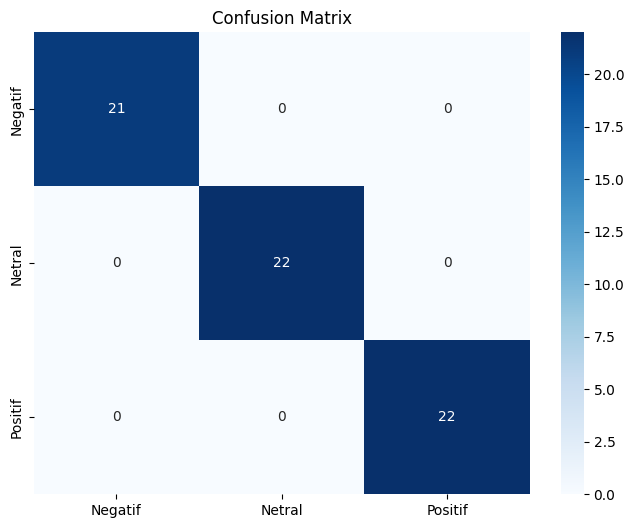

In [64]:
# ## **Step 9: Evaluation**
# %%
# 1. Predictions
y_pred = np.argmax(model.predict(X_test_pad), axis=1)

# 2. Classification Report
print(classification_report(y_test, y_pred, target_names=sentiment_map.keys()))

# 3. Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=sentiment_map.keys(),
            yticklabels=sentiment_map.keys())
plt.title('Confusion Matrix')
plt.show()

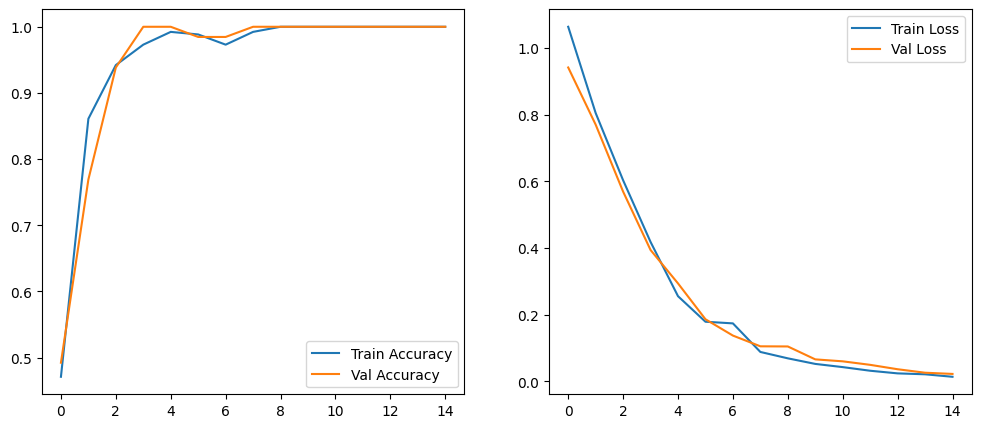

In [62]:
# 4. Training History
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


In [63]:
 ## **Step 10: Prediction Demo**
# %%
def predict_sentiment(text):
    # Preprocess
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len)
    
    # Predict
    proba = model.predict(padded, verbose=0)[0]
    pred = np.argmax(proba)
    
    # Lexicon score
    lex_score = get_lexicon_score(cleaned)
    
    return {
        'text': text,
        'cleaned': cleaned,
        'sentimen': list(sentiment_map.keys())[pred],
        'confidence': round(proba[pred]*100, 2),
        'lexicon_score': lex_score,
        'final_score': round(0.7*proba[pred] + 0.3*(1 if lex_score > 0 else (-1 if lex_score < 0 else 0)), 2)
    }

# Test
test_texts = [
    "Pengajaran ustadz sangat memuaskan",
    "Fasilitas asrama kurang bersih",
    "Saya netral saja dengan pelatihan ini"
]

results = [predict_sentiment(text) for text in test_texts]
result_df = pd.DataFrame(results)
display(result_df)

,text,cleaned,sentimen,confidence,lexicon_score,final_score
0,Pengajaran ustadz sangat memuaskan,ajar ustadz sangat muas,Netral,71.21,-3.0,0.20
1,Fasilitas asrama kurang bersih,fasilitas asrama kurang bersih,Negatif,42.51,-3.0,-0.00
2,Saya netral saja dengan pelatihan ini,netral dengan latih,Negatif,74.66,-4.0,0.22
